In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
import yfinance as yf
df = yf.download(tickers="TSLA",period="500d",interval="60m",auto_adjust=True)
df.tail()
df.shape

[*********************100%***********************]  1 of 1 completed


(3492, 5)

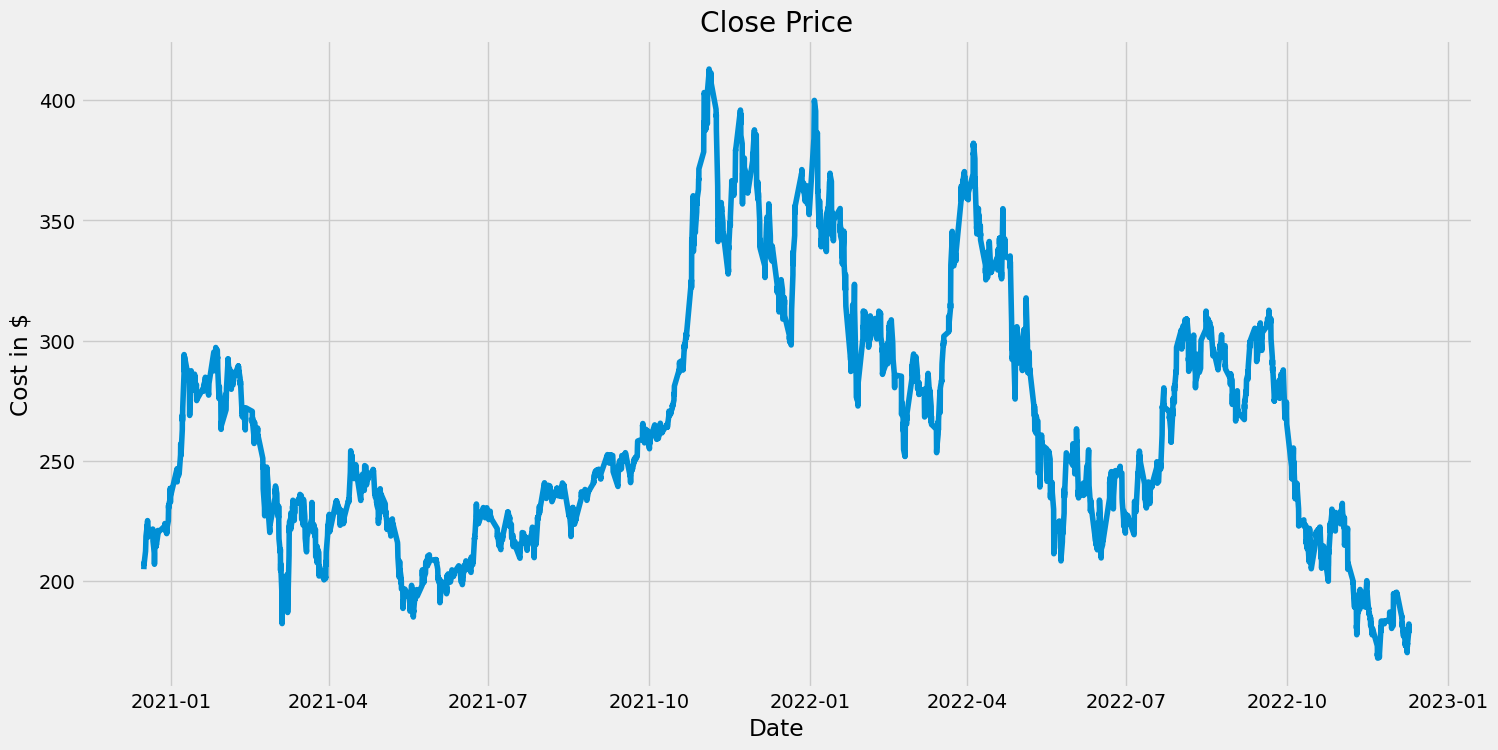

In [3]:
#visualising the closing price
plt.figure(figsize=(16,8))
plt.title('Close Price')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Cost in $')
plt.show()


In [4]:
data=df.filter(['Close'])
#converting data frame to a numpy array
dataset=data.values

#training the dataset
training_data_len=math.ceil(len(dataset)* .8)
training_data_len

2794

In [5]:
#scaling the data
scaler= MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data

array([[0.15095834],
       [0.15515515],
       [0.15790907],
       ...,
       [0.05100905],
       [0.0455405 ],
       [0.04562213]])

In [6]:
#create scaled training data set
train_data=scaled_data[0:training_data_len,:]

x_train=[]
y_train=[]
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0]) #consists of 60 values
    y_train.append(train_data[i,0]) #consists of 61st value

    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.15095834, 0.15515515, 0.15790907, 0.16043908, 0.15958217,
       0.16232861, 0.16207139, 0.18161786, 0.18825172, 0.1929486 ,
       0.19351989, 0.19705917, 0.19568259, 0.20700654, 0.2262606 ,
       0.21751436, 0.22466235, 0.23345449, 0.23276931, 0.20502223,
       0.21951386, 0.21639898, 0.20728543, 0.20899931, 0.21909219,
       0.21633099, 0.21203641, 0.1988248 , 0.17850971, 0.16382605,
       0.1593237 , 0.16412325, 0.17711451, 0.17907191, 0.18564419,
       0.19089953, 0.18935757, 0.19389623, 0.19190121, 0.19226167,
       0.19395519, 0.19339978, 0.20912166, 0.21667102, 0.2166397 ,
       0.21327047, 0.2242966 , 0.22847442, 0.22362611, 0.22486926,
       0.22374753, 0.22181946, 0.2178544 , 0.21305279, 0.21433821,
       0.21135242, 0.22102369, 0.21684786, 0.21827606, 0.22086049])]
[0.2329597185161626]

[array([0.15095834, 0.15515515, 0.15790907, 0.16043908, 0.15958217,
       0.16232861, 0.16207139, 0.18161786, 0.18825172, 0.1929486 ,
       0.19351989, 0.19705917, 0.195

In [7]:
#converting x and y train dataset into numpy array
x_train,y_train =np.array(x_train),np.array(y_train)

In [8]:
#Reshaping the x dataset
#LSTM expects data in 3d we have data in 2d that is why it is necessary to reshape
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2734, 60, 1)

In [9]:
#building LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1))) #first neural layer
model.add(LSTM(50,return_sequences=False)) #2nd neural layer
model.add(Dense(25))#3rd neural layre
model.add(Dense(1))#4th layer

In [10]:
#compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [11]:
#training the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

2734/2734 [==============================] - 97s 34ms/step - loss: 0.0020


In [12]:
#creating the testing dataset
test_data=scaled_data[training_data_len-60: ,]
#creating x and y test datasets
x_test=[]
y_test=dataset[training_data_len:,]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [13]:
#convert data into numpy array
x_test=np.array(x_test)

In [14]:
#reshaping data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [15]:
#Get the models predicted
predictions=model.predict(x_test)

predictions=scaler.inverse_transform(predictions) #reverse scaling the values

22/22 [==============================] - 1s 14ms/step


In [16]:
#getting the root mean squared error(RMSE). Lower the value accurate is the prediction
rmse=np.sqrt(np.mean(((predictions-y_test)**2)))
rmse

5.007594826080434

C:\Users\rohit\AppData\Local\Temp\ipykernel_6892\1668005660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions


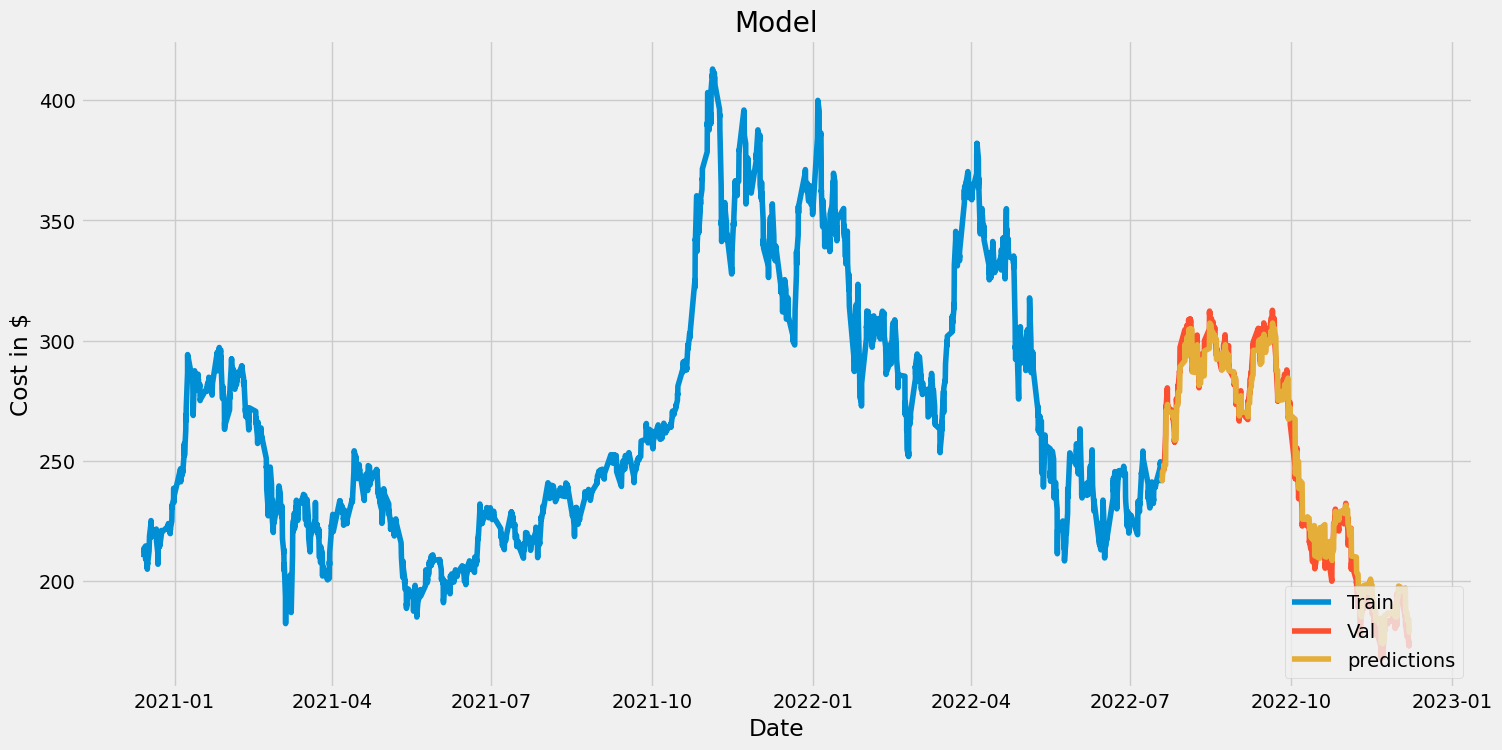

In [17]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions

#visualising data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Cost in $')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','predictions'],loc='lower right')

In [18]:
#Showing actual price and predicted pricr
valid

,Close,Predictions
Datetime,,
2022-07-19 09:30:00,241.323425,242.856445
2022-07-19 10:30:00,242.468338,241.790878
2022-07-19 11:30:00,243.000000,241.809525
2022-07-19 12:30:00,243.849991,242.392197
2022-07-19 13:30:00,245.248795,243.289230
...,...,...
2022-12-07 12:30:00,174.630493,179.874741
2022-12-07 13:30:00,173.289993,179.421860
2022-12-07 14:30:00,173.029999,179.039871
